# Pollution Prediction from Open‑Meteo (Delhi · Chennai · Pune · Panipat) — **v2**
**Fix:** Weather data now comes from **Historical Forecast API** (no more 400 errors).  
**Includes:** exhaustive EDA (lots of plots), PCA, Random Forest, Jaccard (K‑Medoids) clustering, GRU/LSTM/Transformer for next‑day PM2.5.

## 0) Setup (run once)

In [1]:
# Colab: install/upgrade packages (uncomment if needed)
!pip  install pandas numpy matplotlib seaborn plotly scipy scikit-learn statsmodels tensorflow

In [2]:
import os, json, math, sys, time, itertools, io, gc, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from datetime import datetime, date
import requests

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, silhouette_score
from sklearn.feature_selection import mutual_info_regression

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
print('Versions -> pandas', pd.__version__, '| numpy', np.__version__, '| sklearn ok | TF', tf.__version__, '| statsmodels', sm.__version__)

Versions -> pandas 2.2.2 | numpy 2.0.2 | sklearn ok | TF 2.19.0 | statsmodels 0.14.5


## 1) Configuration: cities, dates, variables

In [47]:
# Four cities
CITIES = {
    "Delhi":    (28.6139, 77.2090),
    # "Chennai":  (13.0827, 80.2707),
    # "Pune":     (18.5204, 73.8567),
    # "Panipat":  (29.3909, 76.9635),
}

# Dates
START_DATE = "2022-08-01"               # CAMS global air quality since Aug 2022
END_DATE   = date.today().isoformat()
TIMEZONE   = "Asia/Kolkata"

# Air quality variables
AQ_VARS = ["pm2_5","pm10","carbon_monoxide","nitrogen_dioxide","sulphur_dioxide","ozone","us_aqi"]

# Weather variables (selected from screenshot — important ones)
WX_VARS = [
    "temperature_2m","relative_humidity_2m","dew_point_2m","apparent_temperature",
    "precipitation","rain","cloud_cover","wind_speed_10m","wind_direction_10m",
    "visibility","vapor_pressure_deficit"
]

print('Range:', START_DATE, '→', END_DATE)

Range: 2022-08-01 → 2025-11-13


## 2) Helper: robust data fetchers

In [48]:
def fetch_openmeteo_air_quality(lat, lon, start_date, end_date, tz=TIMEZONE, hourly_vars=None):
    """Air Quality from CAMS global (3‑hourly native). Accepts start/end date."""
    base = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": lat, "longitude": lon,
        "timezone": tz,
        "start_date": start_date, "end_date": end_date,
        "hourly": ",".join(hourly_vars or AQ_VARS),
        "domains": "cams_global",
    }
    r = requests.get(base, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()
    hourly = data.get("hourly", {})
    df = pd.DataFrame(hourly)
    if not df.empty:
        df["time"] = pd.to_datetime(df["time"])
        df = df.set_index("time")
    return df

def fetch_openmeteo_weather_hist(lat, lon, start_date, end_date, tz=TIMEZONE, hourly_vars=None):
    """Weather from Historical Forecast API (fix for 400 errors on /v1/forecast)."""
    base = "https://historical-forecast-api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat, "longitude": lon,
        "timezone": tz,
        "start_date": start_date, "end_date": end_date,
        "hourly": ",".join(hourly_vars or WX_VARS),
    }
    r = requests.get(base, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()
    hourly = data.get("hourly", {})
    df = pd.DataFrame(hourly)
    if not df.empty:
        df["time"] = pd.to_datetime(df["time"])
        df = df.set_index("time")
    return df

## 3) Download & merge (hourly → daily)

In [49]:
def build_city_dataframe(name, lat, lon, start_date=START_DATE, end_date=END_DATE):
    aq = fetch_openmeteo_air_quality(lat, lon, start_date, end_date)
    wx = fetch_openmeteo_weather_hist(lat, lon, start_date, end_date)
    df = aq.join(wx, how="outer").sort_index()
    # Fill 3‑hourly → hourly gaps (AQ) then daily aggregate
    df = df.ffill()
    df["city"] = name
    daily = df.resample("D").mean(numeric_only=True)
    daily["city"] = name
    return daily

daily_all = []
for name, (lat, lon) in CITIES.items():
    print("Fetching:", name)
    daily_all.append(build_city_dataframe(name, lat, lon))

DATA = pd.concat(daily_all).reset_index().rename(columns={"index":"date"})
DATA = DATA.dropna(subset=["pm2_5"]).reset_index(drop=True)
print("Final shape:", DATA.shape)
DATA.head()

Fetching: Delhi
Final shape: (1198, 20)


,time,pm2_5,pm10,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,us_aqi,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,cloud_cover,wind_speed_10m,wind_direction_10m,visibility,vapor_pressure_deficit,city
0,2022-08-04,43.594737,63.178947,750.105263,52.600000,60.931579,69.631579,NaN,31.445833,61.458333,23.020833,35.537500,0.345833,0.000,95.000000,10.700000,112.083333,21169.166667,1.808333,Delhi
1,2022-08-05,43.929167,63.750000,918.541667,49.037500,43.504167,72.208333,107.263158,31.329167,63.291667,23.287500,35.387500,0.625000,0.000,73.250000,12.554167,114.625000,19069.166667,1.747917,Delhi
2,2022-08-06,73.745833,107.050000,1395.875000,81.204167,69.608333,105.291667,160.166667,33.116667,51.541667,21.575000,36.708333,0.000000,0.000,63.583333,8.641667,127.083333,24140.000000,2.512500,Delhi
3,2022-08-07,42.170833,61.029167,902.166667,65.804167,48.504167,64.833333,153.041667,30.804167,64.250000,23.116667,34.945833,0.370833,0.175,98.625000,10.604167,116.250000,21180.000000,1.631667,Delhi
4,2022-08-08,52.733333,75.850000,1179.041667,65.000000,57.987500,75.333333,119.666667,31.500000,61.000000,22.745833,35.587500,0.000000,0.000,71.916667,9.762500,95.125000,24140.000000,1.900000,Delhi


In [50]:
# --- Fix datetime column name for EDA ---
# Depending on pandas, the reset_index() after resample may produce 'time' instead of 'date'.
if 'time' in DATA.columns and 'date' not in DATA.columns:
    DATA = DATA.rename(columns={'time':'date'})
# Ensure proper dtype
DATA['date'] = pd.to_datetime(DATA['date'])

In [51]:
# --- Robust gap handling BEFORE modeling/EDA heavy steps ---
# Interpolate within each city on daily frequency, then fill edges with median per column.
DATA = DATA.sort_values(['city','date'])
def _city_impute(g):
    g = g.set_index('date').asfreq('D')
    num_cols = g.select_dtypes('number').columns
    g[num_cols] = g[num_cols].interpolate(limit_direction='both')
    # fill any remaining with column medians
    g[num_cols] = g[num_cols].fillna(g[num_cols].median())
    return g.reset_index()

DATA = DATA.groupby('city', group_keys=False).apply(_city_impute)

In [52]:
# === Save combined & per-city datasets (after DATA exists) ===
import os
if 'DATA' not in globals():
    raise RuntimeError("DATA not found. Run the download/merge cells first.")
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)
DATA.to_csv(f"{OUT_DIR}/daily_all_cities.csv", index=False)
for c, g in DATA.groupby('city'):
    g.to_csv(f"{OUT_DIR}/daily_{c.lower()}.csv", index=False)
print("Saved CSVs to", OUT_DIR)

Saved CSVs to outputs


## 4) EDA — **everything**

,rows
city,
Delhi,1198


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
date,1198,NaN,NaN,NaN,2024-03-24 12:00:00,2022-08-04 00:00:00,2023-05-30 06:00:00,2024-03-24 12:00:00,2025-01-17 18:00:00,2025-11-13 00:00:00,NaN
pm2_5,1198.0,NaN,NaN,NaN,70.134772,0.620833,44.203125,60.908333,89.308333,256.733333,35.759611
pm10,1198.0,NaN,NaN,NaN,142.817727,0.895833,78.069792,114.652083,167.01875,929.841667,106.766907
carbon_monoxide,1198.0,NaN,NaN,NaN,1000.003392,60.333333,551.864583,764.9375,1223.354167,6311.625,677.655938
nitrogen_dioxide,1198.0,NaN,NaN,NaN,42.246574,0.0,26.655208,36.379167,52.967708,155.783333,21.944172
sulphur_dioxide,1198.0,NaN,NaN,NaN,37.698079,0.529167,22.325,29.633333,44.927083,229.683333,24.492105
ozone,1198.0,NaN,NaN,NaN,85.578609,21.458333,69.21875,83.708333,98.458333,166.0,23.844194
us_aqi,1198.0,NaN,NaN,NaN,159.437939,13.5,126.1875,155.25,172.989583,726.458333,65.591557
temperature_2m,1198.0,NaN,NaN,NaN,25.554845,8.433333,19.614583,27.916667,30.679167,39.620833,6.850971
relative_humidity_2m,1198.0,NaN,NaN,NaN,64.349645,19.208333,54.34375,67.083333,77.083333,93.416667,16.265176


,missing_ratio
date,0.0
pm2_5,0.0
pm10,0.0
carbon_monoxide,0.0
nitrogen_dioxide,0.0
sulphur_dioxide,0.0
ozone,0.0
us_aqi,0.0
temperature_2m,0.0
relative_humidity_2m,0.0


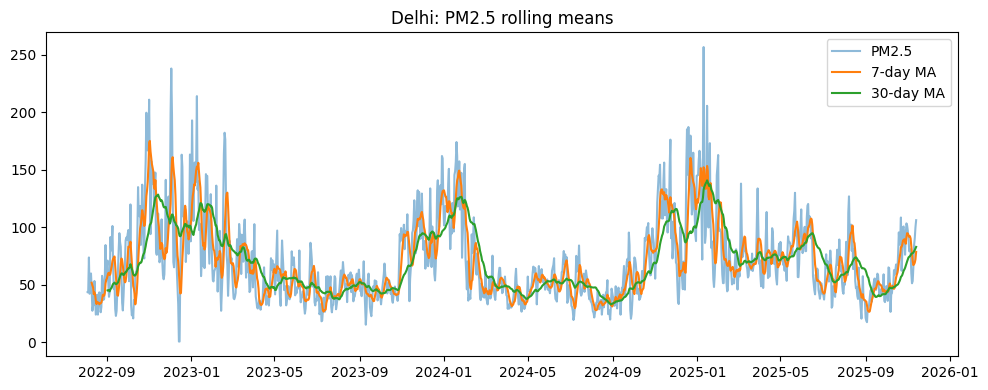

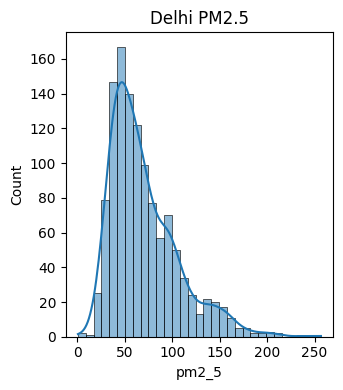

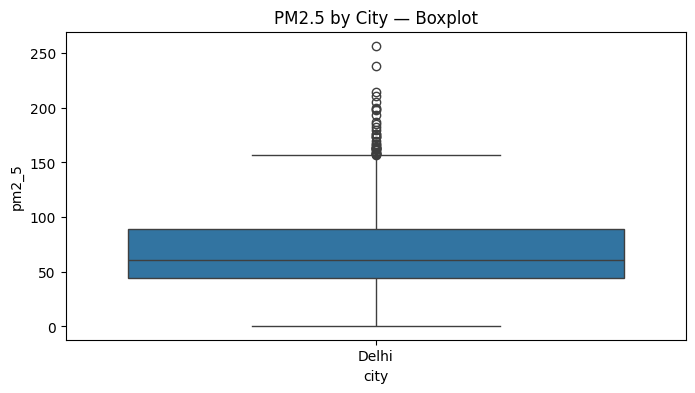

,date,city,pm2_5,pm2_5_outlier
85,2022-10-28,Delhi,199.625000,1
89,2022-11-01,Delhi,210.970833,1
120,2022-12-02,Delhi,199.037500,1
121,2022-12-03,Delhi,238.075000,1
122,2022-12-04,Delhi,198.254167,1


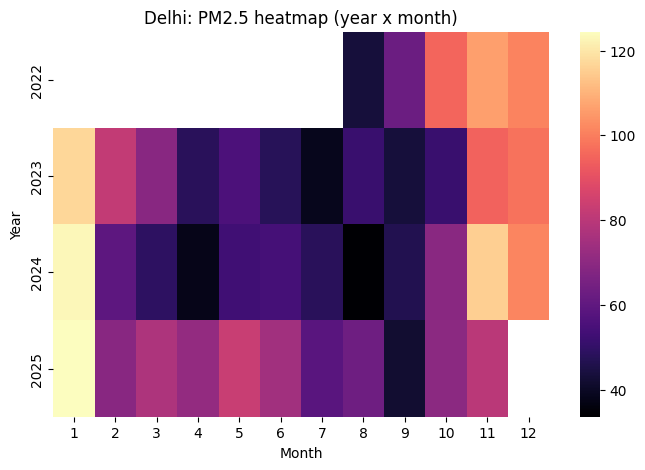

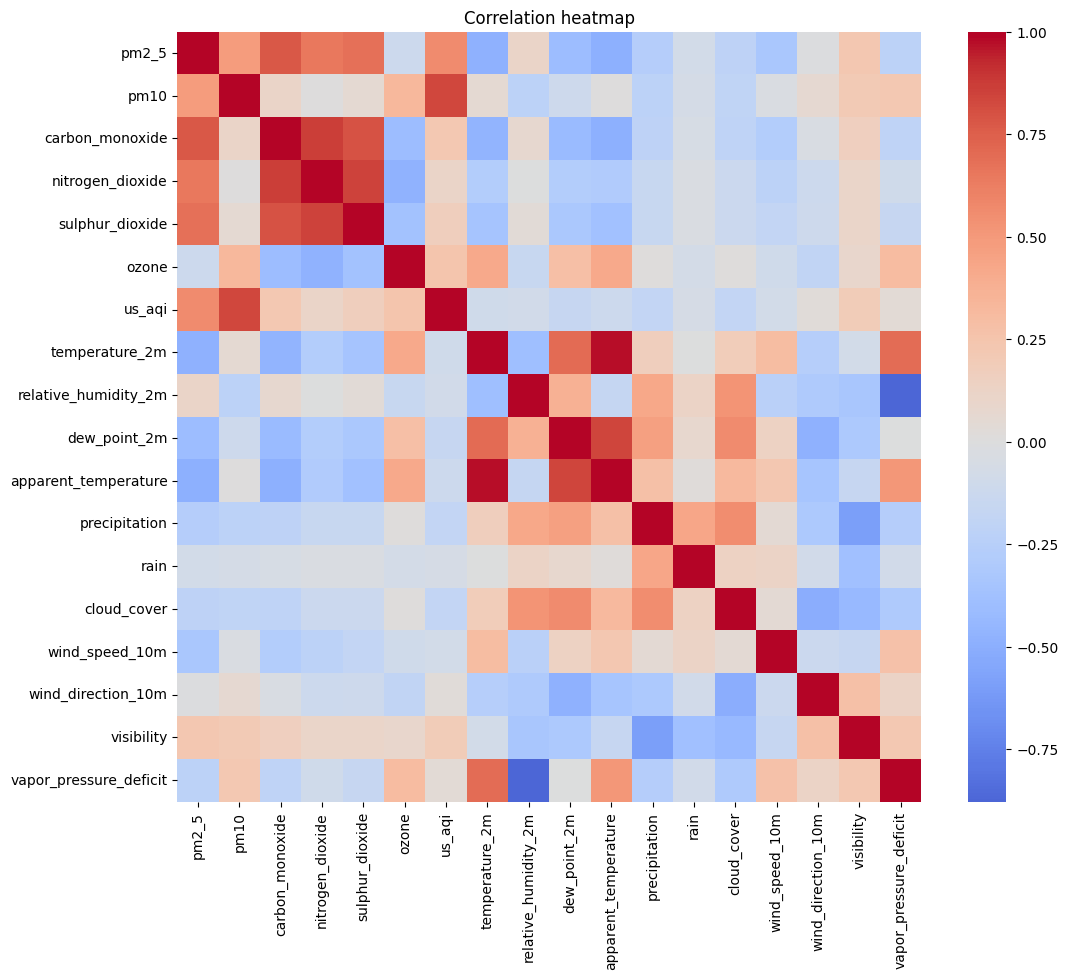

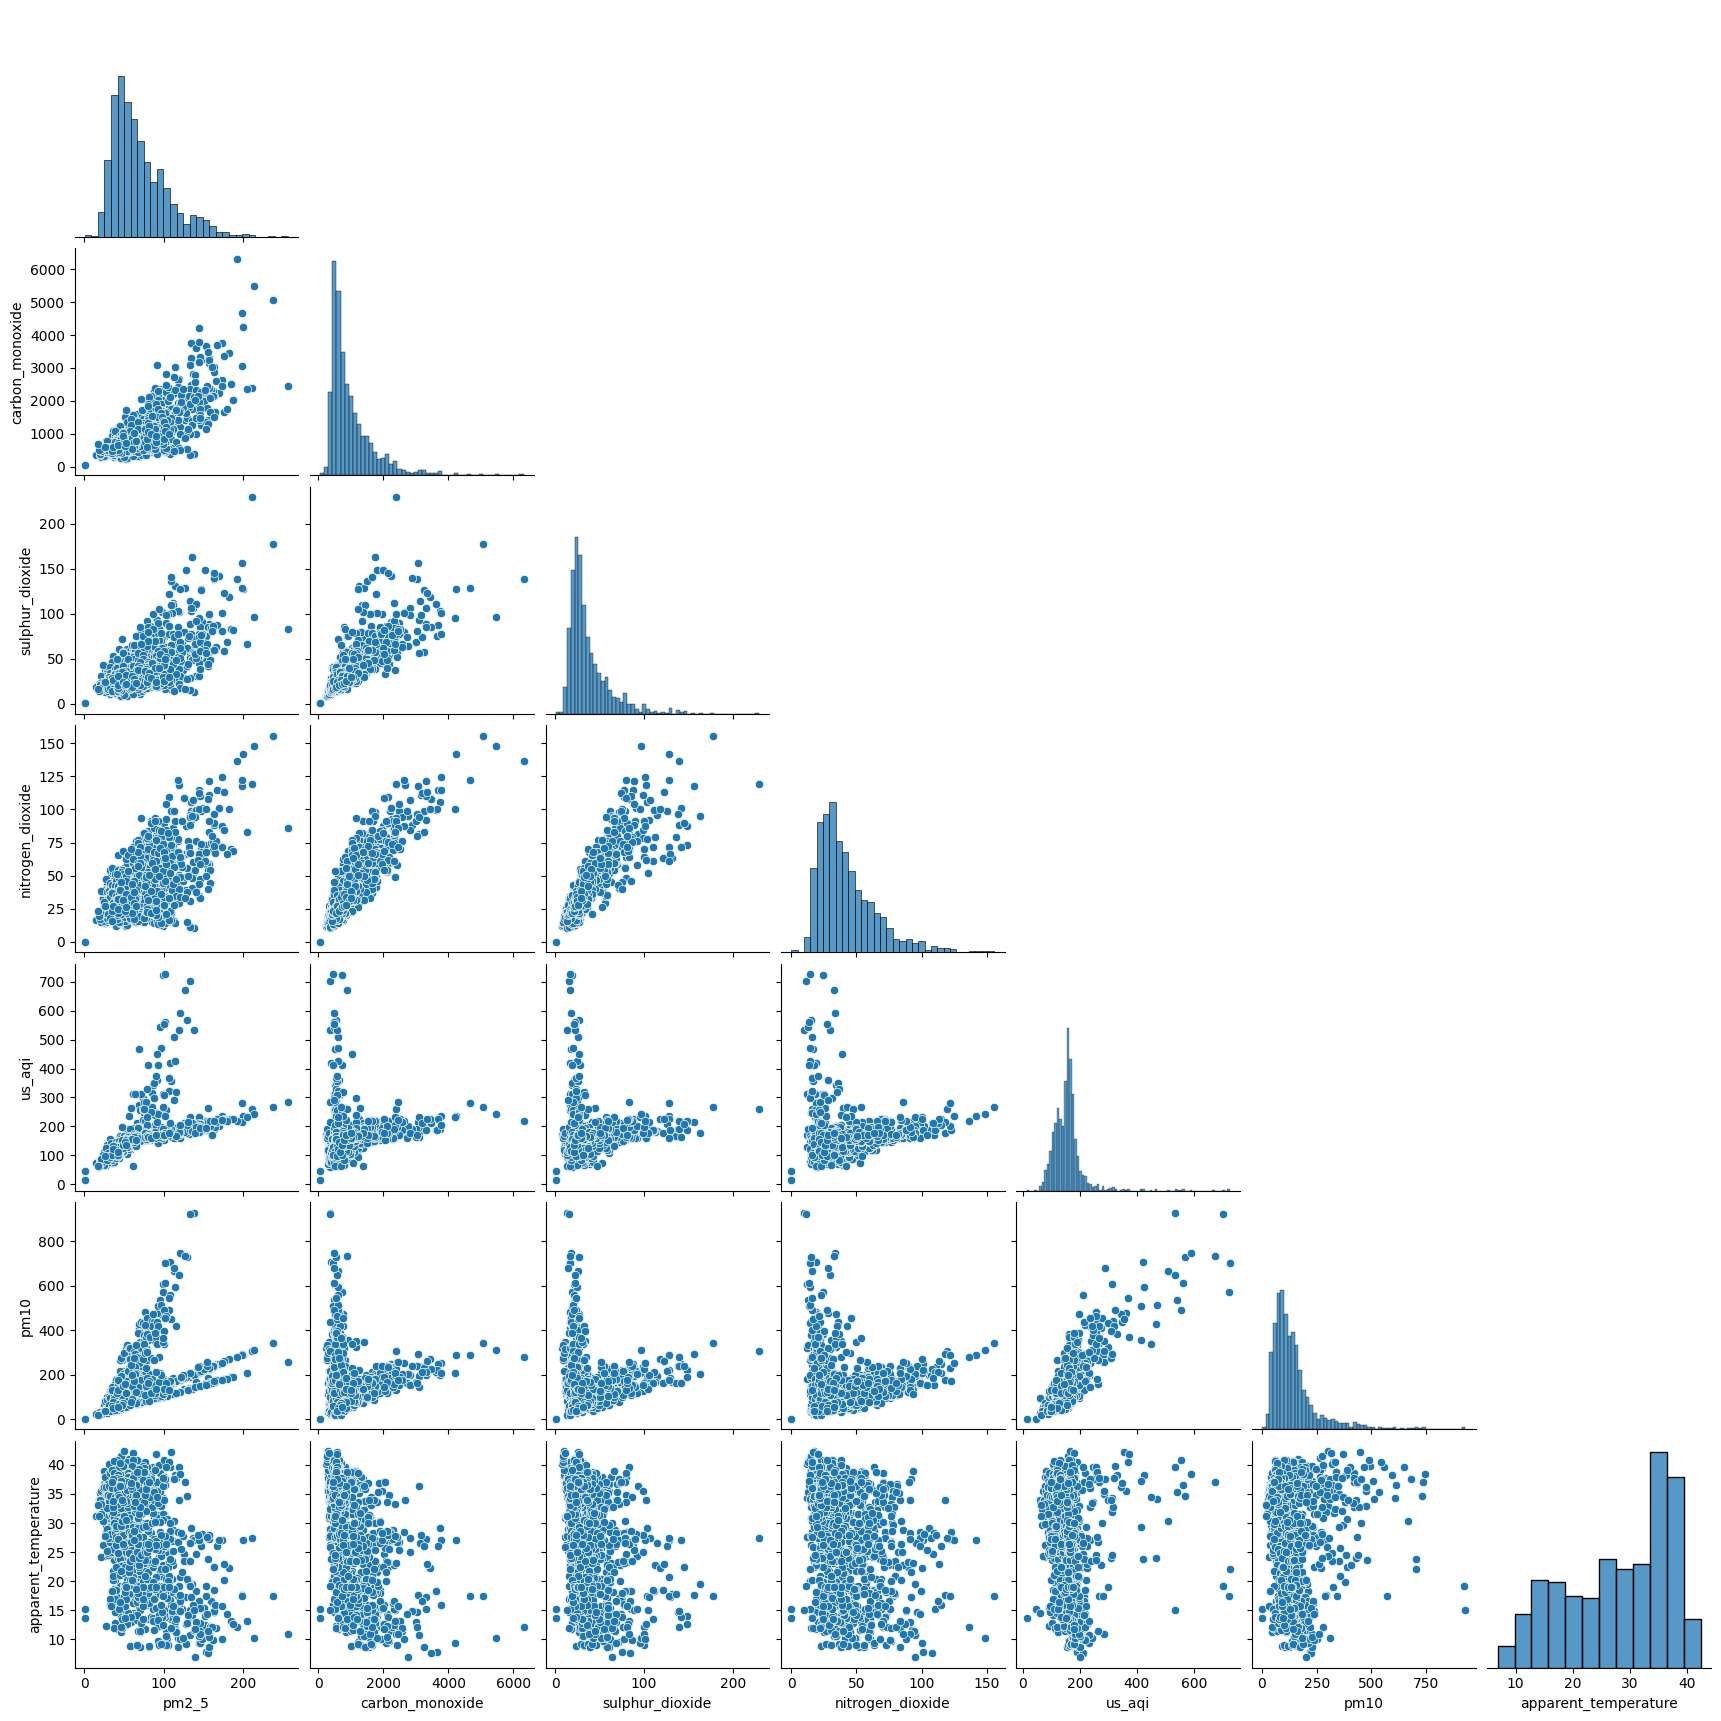

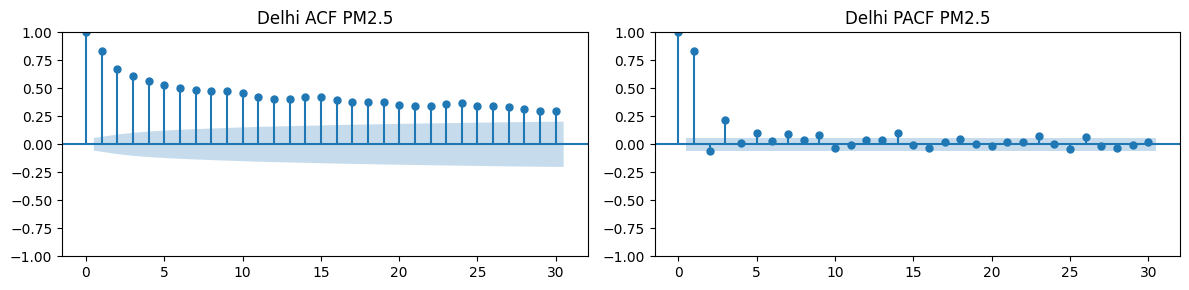

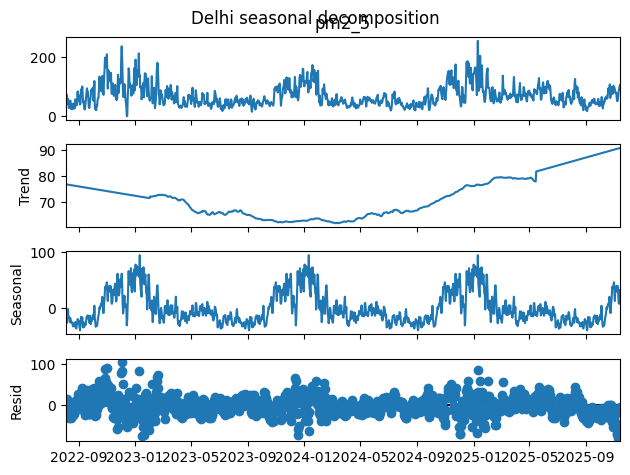

In [53]:
# ---- Overview ----
display(DATA.groupby('city').size().rename('rows').to_frame())
display(DATA.describe(include='all').T)

# Missingness per column
miss = DATA.isna().mean().sort_values(ascending=False)
display(miss.to_frame('missing_ratio'))

# ---- Time trends ----
fig = px.line(DATA, x='date', y='pm2_5', color='city', title='PM2.5 — Daily mean')
fig.show()

# Rolling stats
for city, g in DATA.groupby('city'):
    g2 = g.sort_values('date')
    plt.figure(figsize=(10,4))
    plt.plot(g2['date'], g2['pm2_5'], label='PM2.5', alpha=0.5)
    plt.plot(g2['date'], g2['pm2_5'].rolling(7).mean(), label='7‑day MA')
    plt.plot(g2['date'], g2['pm2_5'].rolling(30).mean(), label='30‑day MA')
    plt.title(f'{city}: PM2.5 rolling means'); plt.legend(); plt.tight_layout(); plt.show()

# ---- Distribution & outliers ----
plt.figure(figsize=(12,4))
for i,(city,g) in enumerate(DATA.groupby('city')):
    ax = plt.subplot(1,4,i+1)
    sns.histplot(g['pm2_5'], kde=True, ax=ax); ax.set_title(f'{city} PM2.5');
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(data=DATA, x='city', y='pm2_5')
plt.title('PM2.5 by City — Boxplot'); plt.show()

# Z-score outliers (flag top extreme days)
z = (DATA['pm2_5'] - DATA['pm2_5'].mean())/DATA['pm2_5'].std()
DATA['pm2_5_outlier'] = (np.abs(z) > 3).astype(int)
display(DATA[['date','city','pm2_5','pm2_5_outlier']].query('pm2_5_outlier==1').head())

# ---- Calendar / seasonal patterns ----
DATA['year'] = pd.to_datetime(DATA['date']).dt.year
DATA['month'] = pd.to_datetime(DATA['date']).dt.month
DATA['dow'] = pd.to_datetime(DATA['date']).dt.dayofweek

# Monthly climatology
monthly = DATA.groupby(['city','month'])['pm2_5'].mean().reset_index()
fig = px.line(monthly, x='month', y='pm2_5', color='city', markers=True, title='Monthly mean PM2.5')
fig.show()

# Month heatmap by city
for city,g in DATA.groupby('city'):
    pivot = g.pivot_table(index=g['date'].dt.year, columns=g['date'].dt.month, values='pm2_5', aggfunc='mean')
    plt.figure(figsize=(8,5)); sns.heatmap(pivot, cmap='magma', annot=False); plt.title(f'{city}: PM2.5 heatmap (year x month)'); plt.ylabel('Year'); plt.xlabel('Month'); plt.show()

# ---- Feature relationships ----
num_cols = DATA.select_dtypes(include=float).columns
corr = DATA[num_cols].corr()
plt.figure(figsize=(12,10)); sns.heatmap(corr, cmap='coolwarm', center=0); plt.title('Correlation heatmap'); plt.show()

# Pairwise scatter against PM2.5 for top correlated features
top_corr = corr['pm2_5'].dropna().sort_values(key=np.abs, ascending=False).index[1:7]
sns.pairplot(DATA[['pm2_5']+list(top_corr)], corner=True); plt.show()

# ---- ACF/PACF & decomposition (per city) ----
for city,g in DATA.groupby('city'):
    g2 = g.sort_values('date').set_index('date')
    s = g2['pm2_5'].asfreq('D').interpolate()
    fig = plt.figure(figsize=(12,3))
    ax1 = plt.subplot(1,2,1); plot_acf(s, ax=ax1, lags=30, title=f'{city} ACF PM2.5')
    ax2 = plt.subplot(1,2,2); plot_pacf(s, ax=ax2, lags=30, title=f'{city} PACF PM2.5')
    plt.tight_layout(); plt.show()
    try:
        dec = seasonal_decompose(s, period=365, model='additive', extrapolate_trend='freq')
        dec.plot(); plt.suptitle(f'{city} seasonal decomposition'); plt.show()
    except Exception as e:
        print('Decompose skipped:', city, e)

## 5) PCA — find relevant components/features

In [54]:
# Save PCA loadings and MI ranking (robust)
import os
from sklearn.impute import SimpleImputer
os.makedirs("outputs", exist_ok=True)

# Recompute PCA loadings safely if 'loadings' is not available in scope
try:
    loadings  # noqa
except NameError:
    FEATURES = [c for c in DATA.columns if c not in ('date','city','pm2_5','pm2_5_outlier','year','month','dow')]
    X = DATA[FEATURES].copy()
    X_imp = SimpleImputer(strategy='median').fit_transform(X)
    X_scaled = StandardScaler().fit_transform(X_imp)
    pca = PCA(n_components=min(15, X_scaled.shape[1]))
    _ = pca.fit_transform(X_scaled)
    loadings = pd.DataFrame(pca.components_[:2].T, index=FEATURES, columns=['PC1','PC2'])

# Recompute MI safely if 'mi_series' missing
try:
    mi_series  # noqa
except NameError:
    FEATURES = [c for c in DATA.columns if c not in ('date','city','pm2_5','pm2_5_outlier','year','month','dow')]
    X = DATA[FEATURES].copy()
    X_imp = SimpleImputer(strategy='median').fit_transform(X)
    mi = mutual_info_regression(X_imp, DATA['pm2_5'])
    mi_series = pd.Series(mi, index=FEATURES).sort_values(ascending=False)

loadings.to_csv("outputs/pca_loadings_pc1_pc2.csv")
mi_series.to_csv("outputs/mi_feature_scores.csv")
print("Saved PCA loadings & MI scores in outputs/")

Saved PCA loadings & MI scores in outputs/


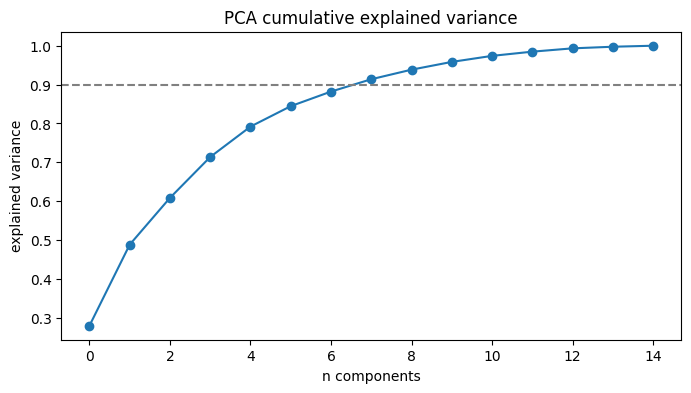

,PC1,PC2
apparent_temperature,0.389647,-0.116481
dew_point_2m,0.374447,0.129120
temperature_2m,0.360580,-0.210032
carbon_monoxide,-0.354759,0.105822
sulphur_dioxide,-0.304695,0.113996
nitrogen_dioxide,-0.295105,0.111842
cloud_cover,0.230693,0.321571
precipitation,0.226441,0.317839
ozone,0.213996,-0.214194
visibility,-0.176294,-0.294190


,PC1,PC2
relative_humidity_2m,0.019866,0.449523
vapor_pressure_deficit,0.126298,-0.427216
cloud_cover,0.230693,0.321571
precipitation,0.226441,0.317839
visibility,-0.176294,-0.294190
pm10,-0.062648,-0.248780
ozone,0.213996,-0.214194
temperature_2m,0.360580,-0.210032
wind_direction_10m,-0.167178,-0.202980
rain,0.076947,0.172036


In [55]:
from sklearn.impute import SimpleImputer
FEATURES = [c for c in DATA.columns if c not in ('date','city','pm2_5','pm2_5_outlier','year','month','dow')]
X = DATA[FEATURES].copy()
# Median imputation for any residual gaps
imputer = SimpleImputer(strategy='median')
X_imp = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)
pca = PCA(n_components=min(15, X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o'); plt.axhline(0.9, ls='--', c='grey')
plt.title('PCA cumulative explained variance'); plt.xlabel('n components'); plt.ylabel('explained variance'); plt.show()
loadings = pd.DataFrame(pca.components_[:2].T, index=FEATURES, columns=['PC1','PC2'])
display(loadings.sort_values('PC1', key=np.abs, ascending=False).head(12))
display(loadings.sort_values('PC2', key=np.abs, ascending=False).head(12))

## 6) Random Forest — supervised baseline

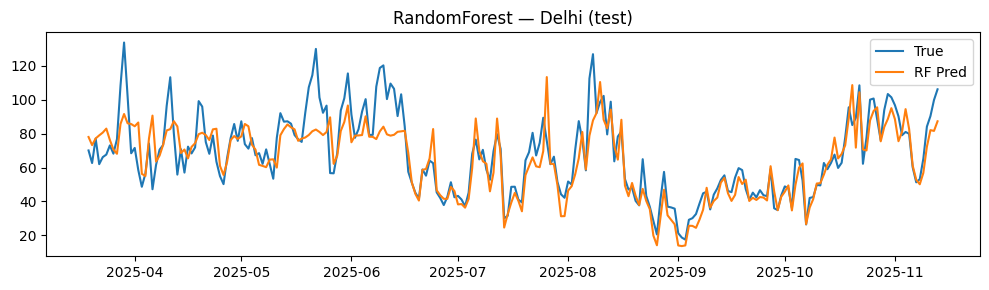

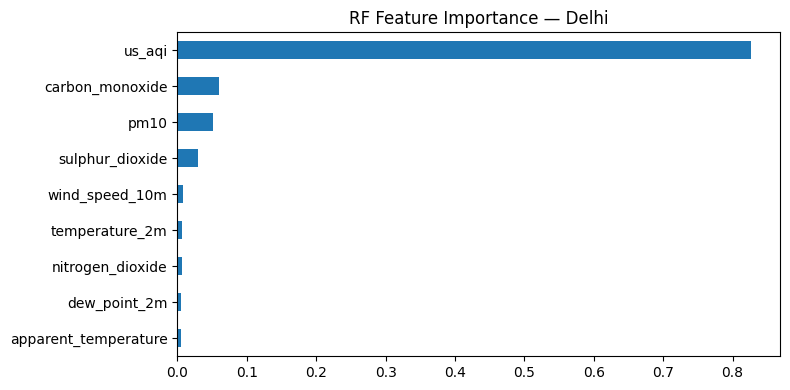

,city,RMSE,MAE,R2,sMAPE
0,Delhi,12.760052,8.950966,0.703034,13.042526


In [56]:

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np, pandas as pd, os, matplotlib.pyplot as plt

os.makedirs("outputs", exist_ok=True)


FEATURES = [c for c in DATA.columns if c not in ('date','city','pm2_5','pm2_5_outlier','year','month','dow')]
X = DATA[FEATURES].copy()
imputer = SimpleImputer(strategy='median')
X_imp = imputer.fit_transform(X)
mi = mutual_info_regression(X_imp, DATA['pm2_5'])
mi_series = pd.Series(mi, index=FEATURES).sort_values(ascending=False)
TOPK = 9
TOP_FEATURES = mi_series.head(TOPK).index.tolist()
# Use the same selected feature list (TOP_FEATURES) you already computed,
# or compute globally with MI beforehand. Here we reuse TOP_FEATURES.
FEATURES = TOP_FEATURES

all_metrics = []
for city, g in DATA.groupby('city'):
    g = g.sort_values('date')
    # Impute only on the city slice (median)
    X = SimpleImputer(strategy='median').fit_transform(g[FEATURES])
    y = g['pm2_5'].values

    # Time-based split PER CITY
    split = int(len(g) * 0.8)
    Xtr, Xte = X[:split], X[split:]
    ytr, yte = y[:split], y[split:]
    dte = g['date'].iloc[split:]

    rf = RandomForestRegressor(
        n_estimators=300, max_depth=18, min_samples_leaf=2,
        random_state=42, n_jobs=-1
    )
    rf.fit(Xtr, ytr)
    yhat = rf.predict(Xte)

    rmse = np.sqrt(mean_squared_error(yte, yhat))
    mae  = mean_absolute_error(yte, yhat)
    r2   = r2_score(yte, yhat)
    smape = 100 * np.mean(2*np.abs(yhat - yte) / (np.abs(yhat) + np.abs(yte) + 1e-6))

    all_metrics.append({"city": city, "RMSE": rmse, "MAE": mae, "R2": r2, "sMAPE": smape})

    # --- Save predictions for this city
    pd.DataFrame({
        "date": dte.values,
        "city": city,
        "pm2_5_true": yte,
        "pm2_5_pred": yhat
    }).to_csv(f"outputs/rf_test_predictions_{city.lower()}.csv", index=False)

    # --- Plot per-city prediction
    plt.figure(figsize=(10,3))
    plt.plot(dte, yte, label="True")
    plt.plot(dte, yhat, label="RF Pred")
    plt.title(f"RandomForest — {city} (test)")
    plt.legend(); plt.tight_layout(); plt.show()

    # --- Optional: per-city feature importance bar
    imp = pd.Series(rf.feature_importances_, index=FEATURES).sort_values(ascending=False)
    plt.figure(figsize=(8,4)); imp.plot(kind='barh'); plt.gca().invert_yaxis()
    plt.title(f"RF Feature Importance — {city}")
    plt.tight_layout(); plt.show()
    imp.to_csv(f"outputs/rf_feature_importance_{city.lower()}.csv")

# Save metrics table
metrics_df = pd.DataFrame(all_metrics).sort_values("city")
display(metrics_df)
metrics_df.to_csv("outputs/rf_citywise_metrics.csv", index=False)


## 7) Clustering — Jaccard similarity + K‑Medoids

In [57]:
BIN_FEATURES = list(dict.fromkeys(TOP_FEATURES + ['rain','precipitation']))
bin_df = DATA[['date','city'] + BIN_FEATURES].copy()

# Binarize per city using 0.7 quantiles
BIN = []
for city, g in bin_df.groupby('city'):
    g2 = g.copy()
    for col in BIN_FEATURES:
        thresh = g2[col].quantile(0.7)
        g2[col] = (g2[col] >= thresh).astype(int)
    BIN.append(g2)
BIN = pd.concat(BIN, ignore_index=True)

# Limit to last 300 days per city
BIN_SAMPLE = BIN.groupby('city').tail(300).reset_index(drop=True)
B = BIN_SAMPLE[BIN_FEATURES].values.astype(bool)

def jaccard_distance_matrix(B_bool):
    A = B_bool.astype(np.uint8)
    inter = A @ A.T
    row_sums = A.sum(axis=1, keepdims=True)
    unions = row_sums + row_sums.T - inter
    unions = np.maximum(unions, 1)
    J = 1.0 - (inter / unions)
    np.fill_diagonal(J, 0.0)
    return J

D = jaccard_distance_matrix(B)

def kmedoids(D, k=4, max_iter=50, random_state=42):
    rng = np.random.default_rng(random_state)
    n = D.shape[0]
    medoids = rng.choice(n, size=k, replace=False)
    labels = np.argmin(D[:, medoids], axis=1)
    for _ in range(max_iter):
        changed = False
        for i in range(n):
            if i in medoids:
                continue
            for m_idx, m in enumerate(medoids.copy()):
                trial = medoids.copy(); trial[m_idx] = i
                new_labels = np.argmin(D[:, trial], axis=1)
                new_cost = D[np.arange(n), trial[new_labels]].sum()
                old_cost = D[np.arange(n), medoids[labels]].sum()
                if new_cost + 1e-6 < old_cost:
                    medoids = trial; labels = new_labels; changed = True
        if not changed: break
    return medoids, labels

k = 4
medoids, labels = kmedoids(D, k=k)
BIN_SAMPLE['cluster'] = labels

try:
    sil = silhouette_score(D, labels, metric='precomputed'); print('Silhouette (Jaccard, k=%d):' % k, round(sil,3))
except Exception as e:
    print('Silhouette error:', e)

fig = px.scatter(BIN_SAMPLE, x='date', y='cluster', color='city', title='Jaccard K‑Medoids clusters over time')
fig.show()
display(BIN_SAMPLE.groupby(['cluster','city']).size().rename('count').to_frame())

Silhouette (Jaccard, k=4): 0.301


,,count
cluster,city,
0,Delhi,74
1,Delhi,45
2,Delhi,100
3,Delhi,81


## 8) Deep Learning — GRU, LSTM, Transformer (next‑day PM2.5)


=== Delhi ===


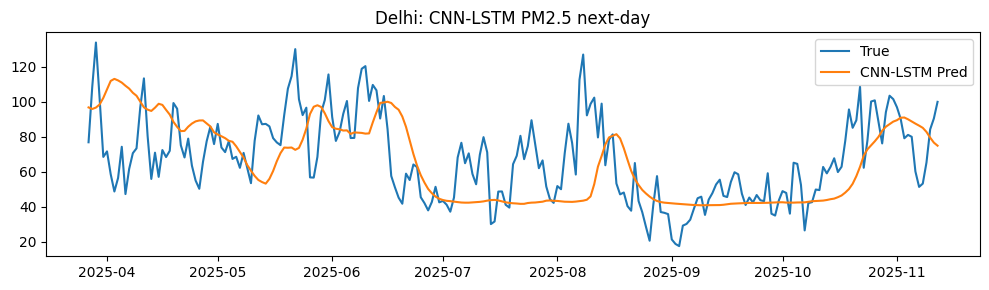

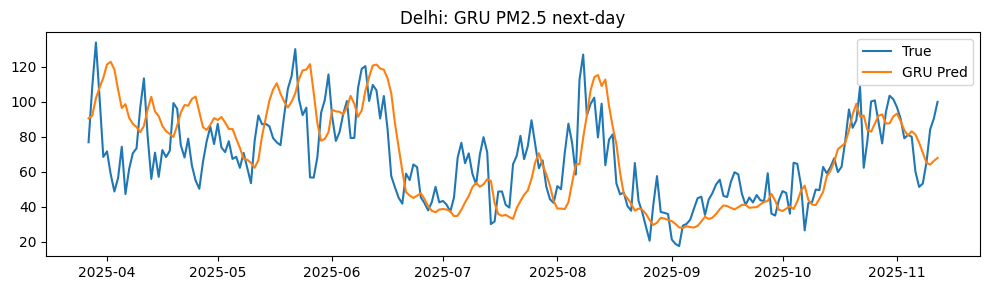

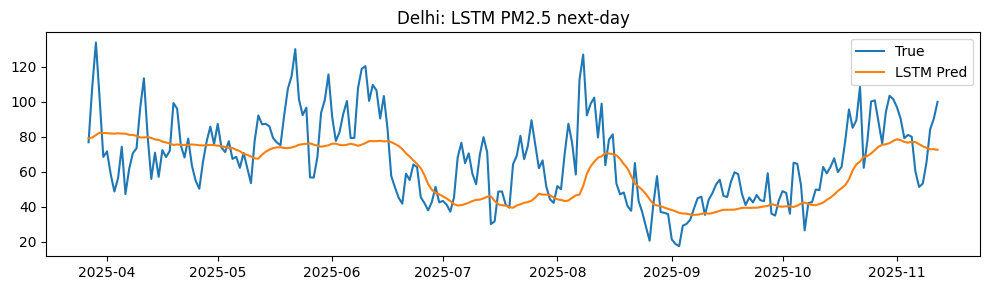

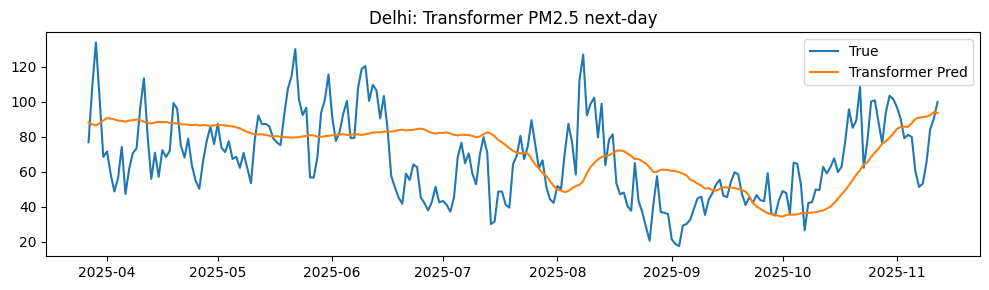

,city,model,RMSE,MAE,R2
2,Delhi,LSTM,20.463835,16.164127,0.255327
1,Delhi,GRU,21.082380,16.208111,0.209629
3,Delhi,Transformer,23.646401,19.285536,0.005690
0,Delhi,CNN-LSTM,24.145298,18.633167,-0.036709


In [58]:
# # Fixed PositionalEncoding: create weights in build(), not in call()
# class PositionalEncoding(layers.Layer):
#     def build(self, input_shape):
#         # input_shape: (None, T, F)
#         T = int(input_shape[1])
#         F = int(input_shape[2])
#         # Create a learnable embedding ONCE
#         self.pos_embed = layers.Embedding(input_dim=T, output_dim=F)
#         # precompute positions [0..T-1] as a constant
#         self.pos_idx = tf.range(start=0, limit=T, delta=1)
#         super().build(input_shape)
#     def call(self, x):
#         pos = self.pos_embed(self.pos_idx)   # (T, F)
#         pos = tf.expand_dims(pos, axis=0)    # (1, T, F)
#         return x + pos

# def build_transformer(input_shape, heads=4, dff=128, dropout=0.1):
#     inp = layers.Input(shape=input_shape)  # (T,F)
#     x = inp
#     x = PositionalEncoding()(x)
#     for _ in range(2):
#         attn = layers.MultiHeadAttention(num_heads=heads, key_dim=input_shape[1])(x, x)
#         x = layers.LayerNormalization()(x + attn)
#         ff = layers.Dense(dff, activation='relu')(x)
#         ff = layers.Dropout(dropout)(ff)
#         ff = layers.Dense(input_shape[1])(ff)
#         x = layers.LayerNormalization()(x + ff)
#     x = layers.GlobalAveragePooling1D()(x)
#     out = layers.Dense(1)(x)
#     model = keras.Model(inp, out)
#     model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
#     return model

# === Better DL: use PM2.5 history features, scale X and y, stronger nets, Huber loss ===
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import os, matplotlib.pyplot as plt

# Window & training params
WINDOW, EPOCHS, BATCH = 45, 25, 64

# Use RF top features + the new history features
hist_feats = [c for c in DATA.columns if c.startswith('pm2_5_lag') or c.startswith('pm2_5_roll')]
DL_FEATURES = list(dict.fromkeys(TOP_FEATURES + hist_feats))  # dedupe, keep order

def make_sequences(df_city, features, window=WINDOW, target='pm2_5'):
    df = df_city.sort_values('date').copy()
    keep = ['date'] + features + [target]
    df = df[keep].dropna().reset_index(drop=True)
    X, y, dates = [], [], []
    for i in range(len(df) - window - 1):
        X.append(df.loc[i:i+window-1, features].values)
        y.append(df.loc[i+window, target])
        dates.append(df.loc[i+window, 'date'])
    return np.array(X, np.float32), np.array(y, np.float32), np.array(dates)

# Models
def build_cnn_lstm(input_shape):
    inp = layers.Input(shape=input_shape)   # (T,F)
    x = layers.Conv1D(64, 3, padding='causal', activation='relu')(inp)
    x = layers.Conv1D(64, 3, padding='causal', activation='relu')(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2))(x)
    x = layers.LSTM(32, dropout=0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(1)(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=keras.losses.Huber())
    return model

def build_gru(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.GaussianNoise(0.03)(inp)
    x = layers.Bidirectional(layers.GRU(64, return_sequences=True, dropout=0.2))(x)
    x = layers.GRU(32, dropout=0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(1e-3), loss=keras.losses.Huber())
    return m

def build_lstm(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.GaussianNoise(0.03)(inp)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2))(x)
    x = layers.LSTM(32, dropout=0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(1e-3), loss=keras.losses.Huber())
    return m

# Positional encoding fix (if you kept Transformer)
class PositionalEncoding(layers.Layer):
    def build(self, input_shape):
        T, F = int(input_shape[1]), int(input_shape[2])
        self.pos_embed = layers.Embedding(input_dim=T, output_dim=F)
        self.pos_idx = tf.range(start=0, limit=T, delta=1)
        super().build(input_shape)
    def call(self, x):
        pos = self.pos_embed(self.pos_idx)       # (T,F)
        return x + tf.expand_dims(pos, 0)

def build_transformer(input_shape, heads=4, dff=128, dropout=0.1):
    inp = layers.Input(shape=input_shape)
    x = PositionalEncoding()(inp)
    for _ in range(2):
        attn = layers.MultiHeadAttention(num_heads=heads, key_dim=input_shape[1])(x, x)
        x = layers.LayerNormalization()(x + attn)
        ff = layers.Dense(dff, activation='relu')(x)
        ff = layers.Dropout(dropout)(ff)
        ff = layers.Dense(input_shape[1])(ff)
        x = layers.LayerNormalization()(x + ff)
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(1)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(1e-3), loss=keras.losses.Huber())
    return m

ES   = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor='val_loss')
RLROP= keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')

RESULTS = []
os.makedirs("outputs", exist_ok=True)
dl_preds_all = []

for city, g in DATA.groupby('city'):
    print(f"\n=== {city} ===")
    # sequences BEFORE scaling
    X_full, y_full, d_full = make_sequences(g, features=DL_FEATURES, window=WINDOW)
    if len(X_full) < 200:
        print("Not enough sequences, skipping", city);
        continue

    # split by time
    n = len(X_full); split = int(n*0.8)
    Xtr, Xte = X_full[:split], X_full[split:]
    ytr, yte = y_full[:split], y_full[split:]
    dte = d_full[split:]

    # scale X on train only (robust to outliers)
    T, F = Xtr.shape[1], Xtr.shape[2]
    x_scaler = RobustScaler().fit(Xtr.reshape(-1, F))
    Xtr = x_scaler.transform(Xtr.reshape(-1, F)).reshape(-1, T, F)
    Xte = x_scaler.transform(Xte.reshape(-1, F)).reshape(-1, T, F)

    # scale y (log1p + standardize) -> improves spike learning
    ytr_log = np.log1p(ytr); yte_log = np.log1p(yte)
    y_scaler = StandardScaler().fit(ytr_log.reshape(-1,1))
    ytr_s = y_scaler.transform(ytr_log.reshape(-1,1)).ravel()
    yte_s = y_scaler.transform(yte_log.reshape(-1,1)).ravel()

    models = {
        "CNN-LSTM": build_cnn_lstm(Xtr.shape[1:]),
        "GRU":       build_gru(Xtr.shape[1:]),
        "LSTM":      build_lstm(Xtr.shape[1:]),
        "Transformer": build_transformer(Xtr.shape[1:])
    }

    for name, model in models.items():
        hist = model.fit(Xtr, ytr_s, validation_split=0.1, epochs=EPOCHS,
                         batch_size=BATCH, callbacks=[ES, RLROP], verbose=0)
        yhat_s = model.predict(Xte, verbose=0).ravel()
        # inverse scale: standard -> expm1 to original units
        yhat = np.expm1(y_scaler.inverse_transform(yhat_s.reshape(-1,1)).ravel())

        rmse = np.sqrt(mean_squared_error(yte, yhat))
        mae  = mean_absolute_error(yte, yhat)
        r2   = r2_score(yte, yhat)
        RESULTS.append({"city":city, "model":name, "RMSE":rmse, "MAE":mae, "R2":r2})

        # save preds
        tmp = pd.DataFrame({"date":dte, "city":city, "model":name, "y_true":yte, "y_pred":yhat})
        dl_preds_all.append(tmp)

        # plots per city/model (stacked)
        plt.figure(figsize=(10,3))
        plt.plot(dte, yte, label='True')
        plt.plot(dte, yhat, label=f'{name} Pred')
        plt.title(f'{city}: {name} PM2.5 next-day')
        plt.legend(); plt.tight_layout(); plt.show()

res_df = pd.DataFrame(RESULTS).sort_values(['city','RMSE'])
display(res_df)
res_df.to_csv("outputs/dl_metrics.csv", index=False)
if dl_preds_all:
    pd.concat(dl_preds_all, ignore_index=True).to_csv("outputs/dl_predictions.csv", index=False)



=== Training: LSTM (single) ===
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.1552 - mean_absolute_error: 0.3416 - mean_absolute_percentage_error: 58030.5195 - val_loss: 0.0203 - val_mean_absolute_error: 0.1201 - val_mean_absolute_percentage_error: 29.5578 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0597 - mean_absolute_error: 0.1845 - mean_absolute_percentage_error: 180339.0625 - val_loss: 0.0216 - val_mean_absolute_error: 0.1227 - val_mean_absolute_percentage_error: 28.2916 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0449 - mean_absolute_error: 0.1619 - mean_absolute_percentage_error: 192730.1719 - val_loss: 0.0253 - val_mean_absolute_error: 0.1325 - val_mean_absolute_percentage_error: 30.3357 - learning_rate: 0.0010
Epoch 4/30
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0267 - mean_absolute_error: 0.1256 - mean_absolute_percentage_error: 29.0210
Epoch 4: ReduceLROnPlateau reducing

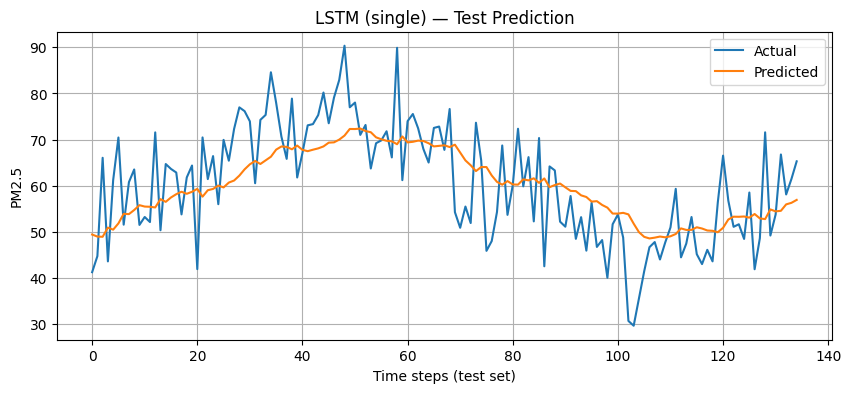


=== Training: LSTM (stacked) ===
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.1913 - mean_absolute_error: 0.3802 - mean_absolute_percentage_error: 218346.9531 - val_loss: 0.0276 - val_mean_absolute_error: 0.1329 - val_mean_absolute_percentage_error: 26.8901 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0473 - mean_absolute_error: 0.1624 - mean_absolute_percentage_error: 211684.1250 - val_loss: 0.0294 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 34.9544 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0312 - mean_absolute_error: 0.1438 - mean_absolute_percentage_error: 205682.4062 - val_loss: 0.0299 - val_mean_absolute_error: 0.1454 - val_mean_absolute_percentage_error: 34.6858 - learning_rate: 0.0010
Epoch 4/30
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0292 - mean_absolute_error: 0.1383 - mean_absolute_percentage_error: 32.0072
Epoch 4: ReduceLROnPlateau reduci

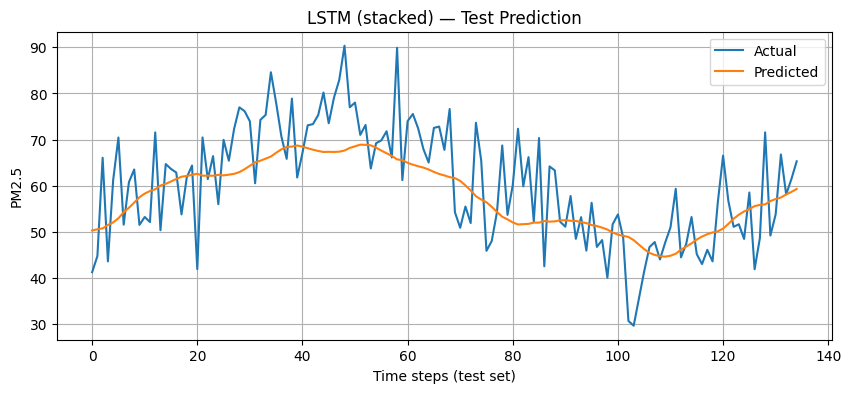


=== Training: BiLSTM (single) ===
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.2074 - mean_absolute_error: 0.3984 - mean_absolute_percentage_error: 344340.0000 - val_loss: 0.0568 - val_mean_absolute_error: 0.2064 - val_mean_absolute_percentage_error: 55.6574 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0632 - mean_absolute_error: 0.2033 - mean_absolute_percentage_error: 148115.4062 - val_loss: 0.0294 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 34.4827 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0352 - mean_absolute_error: 0.1439 - mean_absolute_percentage_error: 208831.7500 - val_loss: 0.0259 - val_mean_absolute_error: 0.1359 - val_mean_absolute_percentage_error: 32.4018 - learning_rate: 0.0010
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0300 - mean_absolute_error: 0.1338 - mean_absolute_percentage_error: 199784.4375 - val_loss: 0.0234 - val_mea

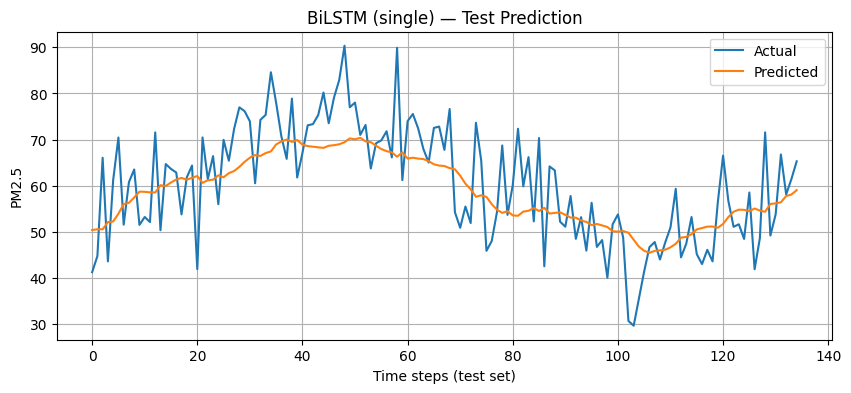


=== Training: GRU (single) ===
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2663 - mean_absolute_error: 0.4725 - mean_absolute_percentage_error: 139410.5312 - val_loss: 0.0241 - val_mean_absolute_error: 0.1263 - val_mean_absolute_percentage_error: 26.4221 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0498 - mean_absolute_error: 0.1730 - mean_absolute_percentage_error: 201885.6562 - val_loss: 0.0243 - val_mean_absolute_error: 0.1299 - val_mean_absolute_percentage_error: 30.5104 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0339 - mean_absolute_error: 0.1416 - mean_absolute_percentage_error: 191203.5781 - val_loss: 0.0273 - val_mean_absolute_error: 0.1385 - val_mean_absolute_percentage_error: 32.7090 - learning_rate: 0.0010
Epoch 4/30
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0314 - mean_absolute_error: 0.1396 - mean_absolute_percentage_error: 32.5744 
Epoch 4: ReduceLROnPlateau reducing

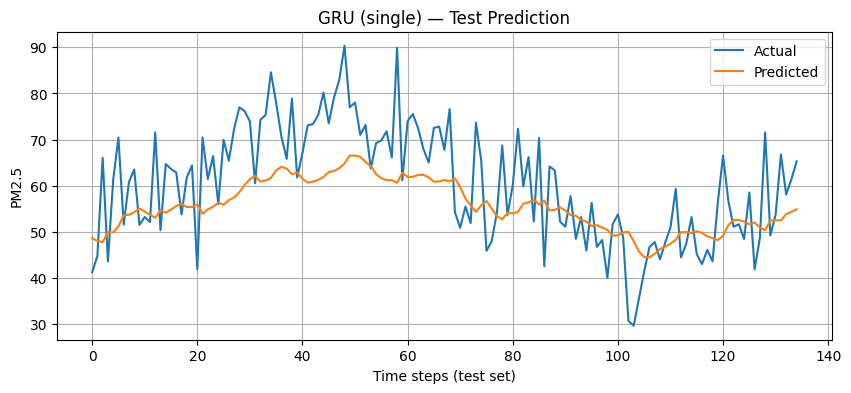


=== Training: GRU (stacked) ===
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1486 - mean_absolute_error: 0.3259 - mean_absolute_percentage_error: 193608.8906 - val_loss: 0.0279 - val_mean_absolute_error: 0.1332 - val_mean_absolute_percentage_error: 26.1792 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0434 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 141407.2656 - val_loss: 0.0288 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 38.3999 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0365 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 194980.0469 - val_loss: 0.0310 - val_mean_absolute_error: 0.1504 - val_mean_absolute_percentage_error: 37.9732 - learning_rate: 0.0010
Epoch 4/30
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0370 - mean_absolute_error: 0.1609 - mean_absolute_percentage_error: 37.5376
Epoch 4: ReduceLROnPlateau reducin

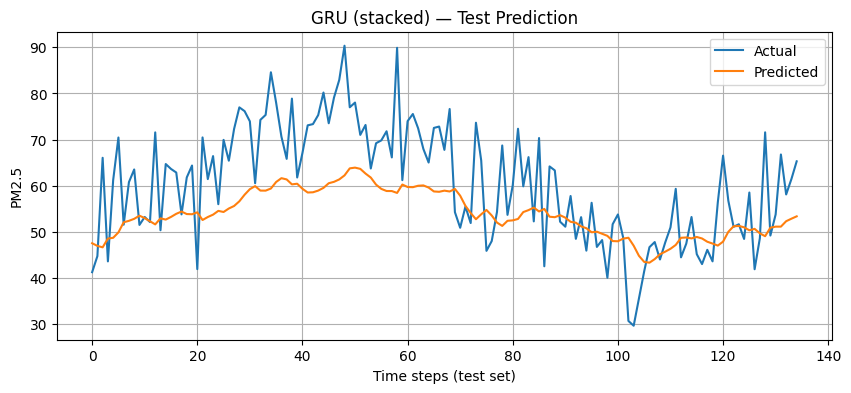


=== Training: BiGRU (single) ===
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.1276 - mean_absolute_error: 0.2990 - mean_absolute_percentage_error: 163698.6875 - val_loss: 0.0294 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 35.4941 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0412 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 176680.6562 - val_loss: 0.0237 - val_mean_absolute_error: 0.1297 - val_mean_absolute_percentage_error: 31.8743 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0334 - mean_absolute_error: 0.1465 - mean_absolute_percentage_error: 194415.3906 - val_loss: 0.0265 - val_mean_absolute_error: 0.1334 - val_mean_absolute_percentage_error: 29.6943 - learning_rate: 0.0010
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0252 - mean_absolute_error: 0.1289 - mean_absolute_percentage_error: 189953.9062 - val_loss: 0.0250 - val_mean

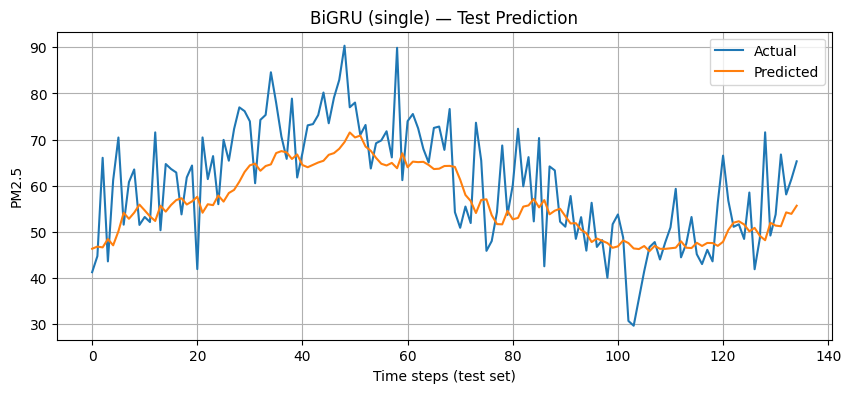


=== Training: CNN + BiLSTM ===
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.1826 - mean_absolute_error: 0.3644 - mean_absolute_percentage_error: 222223.3750 - val_loss: 0.0343 - val_mean_absolute_error: 0.1552 - val_mean_absolute_percentage_error: 35.1343 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0412 - mean_absolute_error: 0.1686 - mean_absolute_percentage_error: 257964.8750 - val_loss: 0.0393 - val_mean_absolute_error: 0.1723 - val_mean_absolute_percentage_error: 46.1937 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0308 - mean_absolute_error: 0.1450 - mean_absolute_percentage_error: 216070.1875 - val_loss: 0.0293 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 39.0427 - learning_rate: 0.0010
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0253 - mean_absolute_error: 0.1268 - mean_absolute_percentage_error: 187339.3125 - val_loss: 0.0200 - val_mean_a

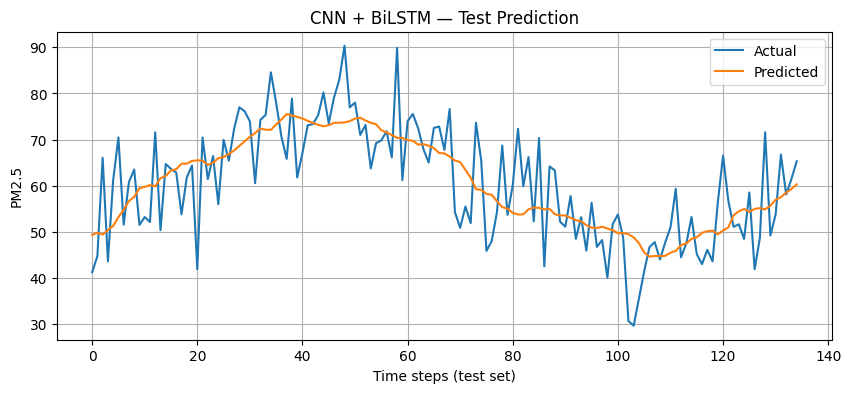


=== Training: Transformer (d=1,h=2) ===
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 358ms/step - loss: 0.1049 - mean_absolute_error: 0.2688 - mean_absolute_percentage_error: 206006.1719 - val_loss: 0.0648 - val_mean_absolute_error: 0.2197 - val_mean_absolute_percentage_error: 61.0147 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0446 - mean_absolute_error: 0.1758 - mean_absolute_percentage_error: 263510.3125 - val_loss: 0.0524 - val_mean_absolute_error: 0.2000 - val_mean_absolute_percentage_error: 53.9384 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0384 - mean_absolute_error: 0.1636 - mean_absolute_percentage_error: 232137.7031 - val_loss: 0.0412 - val_mean_absolute_error: 0.1757 - val_mean_absolute_percentage_error: 43.8470 - learning_rate: 0.0010
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0369 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 241784.4375 - val_loss: 0.0434 - va

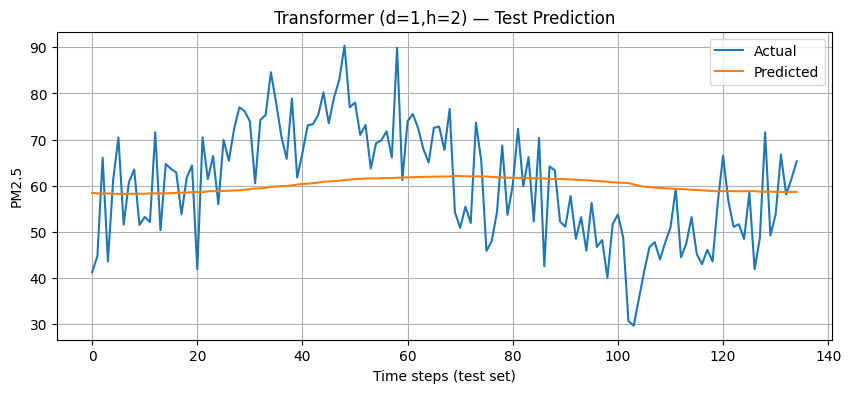


=== Training: Transformer (d=2,h=4) ===
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 555ms/step - loss: 0.1587 - mean_absolute_error: 0.3090 - mean_absolute_percentage_error: 201984.8281 - val_loss: 0.0417 - val_mean_absolute_error: 0.1689 - val_mean_absolute_percentage_error: 37.7708 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0365 - mean_absolute_error: 0.1607 - mean_absolute_percentage_error: 274216.1562 - val_loss: 0.0482 - val_mean_absolute_error: 0.1918 - val_mean_absolute_percentage_error: 50.6287 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0386 - mean_absolute_error: 0.1633 - mean_absolute_percentage_error: 226262.8906 - val_loss: 0.0427 - val_mean_absolute_error: 0.1784 - val_mean_absolute_percentage_error: 44.9010 - learning_rate: 0.0010
Epoch 4/30
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0352 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 37.5438  
Epoch 4: ReduceLROnPlat

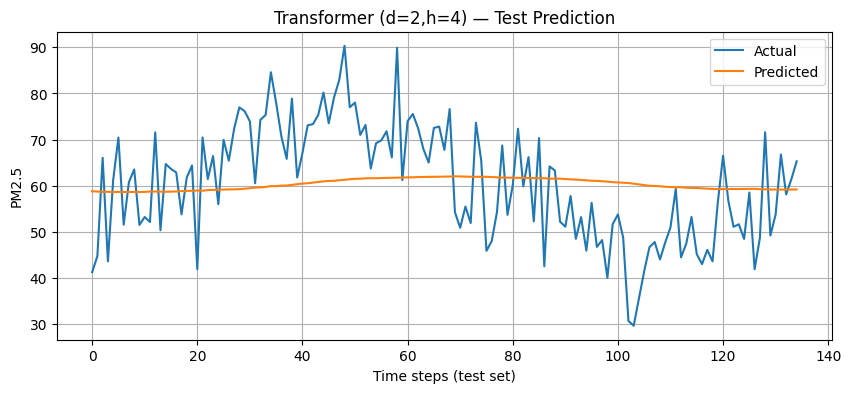


=== Test Metrics (lower is better) ===


,MAE,RMSE,MAPE%
CNN + BiLSTM,6.563605,8.240791,11.651283
BiLSTM (single),7.124720,8.688370,12.249722
LSTM (stacked),7.340241,9.056836,12.406141
LSTM (single),7.463794,9.154444,13.211478
BiGRU (single),7.797737,9.657770,12.763943
GRU (single),8.553154,10.467951,13.872890
GRU (stacked),9.280711,11.511546,14.649137
"Transformer (d=1,h=2)",10.391296,12.161589,18.593233
"Transformer (d=2,h=4)",10.417535,12.190817,18.697947



Best model by RMSE: CNN + BiLSTM


In [7]:
# === Deep Learning Extensions: LSTM/GRU variants + Transformer (Self-Attention) ===
# Paste this as the LAST CELL. It is defensive: it will try to reuse existing splits if available.
# If not available, it will auto-detect a PM2.5 column and build a univariate dataset.

# ----------------------------
# Config (edit ONLY if auto-detect fails)
# ----------------------------
SOURCE_DF = None        # e.g., df  (if None, the code will try to find a suitable DataFrame in globals())
TIME_COL  = None        # e.g., "datetime"  (optional; only used if re-building from a DataFrame)
TARGET_COL = None       # e.g., "pm2_5"     (optional; will auto-guess if None)

LOOKBACK = 48           # past steps per sample (e.g., 48 hours)
HORIZON  = 1            # predict t+1
TEST_RATIO = 0.2
EPOCHS = 30
BATCH_SIZE = 32
PATIENCE = 6
VERBOSE = 1

# ----------------------------
# Imports
# ----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inspect
import types
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set reproducibility (optional)
tf.keras.utils.set_random_seed(42)

# ----------------------------
# Helpers to discover existing splits or build from a DataFrame/Series
# ----------------------------
def _find_existing_split(globs):
    keys = globs.keys()
    required = ["X_train","y_train","X_test","y_test"]
    if all(k in keys for k in required):
        X_train, y_train = globs["X_train"], globs["y_train"]
        X_test,  y_test  = globs["X_test"],  globs["y_test"]
        # sanity check
        if all(isinstance(a, np.ndarray) for a in [X_train,y_train,X_test,y_test]) and X_train.ndim==3:
            return X_train, y_train, X_test, y_test, None
    return None

def _guess_pm_column(df: pd.DataFrame):
    candidates = [c for c in df.columns]
    # rank likely PM names
    priority = ["pm2_5","pm25","PM2.5","pm2.5","pm","PM","pm_2_5","pm_25"]
    cand_lower = {c.lower():c for c in candidates}
    for p in priority:
        if p in cand_lower:
            return cand_lower[p]
    # fallback: numeric column with variance
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        return numeric_cols[0]
    raise ValueError("Could not find a PM2.5-like column. Please set TARGET_COL manually.")

def _find_dataframe_in_globals(globs):
    # pick a pandas DataFrame in globals by heuristic
    for k, v in globs.items():
        if isinstance(v, pd.DataFrame) and len(v) > 100:  # skip tiny frames
            return v
    raise ValueError("No suitable DataFrame found in globals. Set SOURCE_DF to your DataFrame.")

def _ensure_datetime_index(df: pd.DataFrame, time_col=None):
    if isinstance(df.index, pd.DatetimeIndex):
        return df.sort_index()
    if time_col and time_col in df.columns:
        out = df.copy()
        out[time_col] = pd.to_datetime(out[time_col], errors="coerce")
        out = out.dropna(subset=[time_col]).set_index(time_col).sort_index()
        return out
    # try to guess a time col
    for cand in ["datetime","time","date","timestamp","ds"]:
        if cand in df.columns:
            out = df.copy()
            out[cand] = pd.to_datetime(out[cand], errors="coerce")
            out = out.dropna(subset=[cand]).set_index(cand).sort_index()
            return out
    # last resort: just return as-is
    return df

def make_supervised(series: np.ndarray, lookback=48, horizon=1):
    X, y = [], []
    for i in range(lookback, len(series)-horizon+1):
        X.append(series[i-lookback:i])
        y.append(series[i+horizon-1])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    # Add feature dimension for univariate
    X = np.expand_dims(X, axis=-1)  # (N, lookback, 1)
    return X, y

def build_or_reuse_dataset():
    # 1) Reuse if available
    reuse = _find_existing_split(globals())
    if reuse is not None:
        X_train, y_train, X_test, y_test, scaler = reuse[0], reuse[1], reuse[2], reuse[3], reuse[4] if len(reuse)>4 else None
        return X_train, y_train, X_test, y_test, scaler

    # 2) Otherwise build from DataFrame/Series
    df = SOURCE_DF if isinstance(SOURCE_DF, pd.DataFrame) else _find_dataframe_in_globals(globals())
    df = _ensure_datetime_index(df, TIME_COL)

    target_col = TARGET_COL if TARGET_COL else _guess_pm_column(df)
    series = df[target_col].astype(float).dropna().values.reshape(-1,1)

    # scale
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series).flatten()

    X, y = make_supervised(series_scaled, lookback=LOOKBACK, horizon=HORIZON)
    N = len(X)
    split = int((1.0 - TEST_RATIO) * N)
    X_train, y_train = X[:split], y[:split]
    X_test,  y_test  = X[split:], y[split:]
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler = build_or_reuse_dataset()
input_shape = X_train.shape[1:]  # (timesteps, features)

# ----------------------------
# Model builders
# ----------------------------
def compile_model(model):
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="mse",
        metrics=[keras.metrics.MAE, keras.metrics.MAPE]
    )
    return model

def make_lstm(units=64, stacked=False, bidir=False, dropout=0.2):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    if stacked:
        if bidir:
            x = layers.Bidirectional(layers.LSTM(units, return_sequences=True, dropout=dropout))(x)
            x = layers.Bidirectional(layers.LSTM(units, dropout=dropout))(x)
        else:
            x = layers.LSTM(units, return_sequences=True, dropout=dropout)(x)
            x = layers.LSTM(units, dropout=dropout)(x)
    else:
        core = layers.LSTM(units, dropout=dropout)
        x = layers.Bidirectional(core)(x) if bidir else core(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    return compile_model(keras.Model(inputs, outputs, name=f"LSTM_{'stacked' if stacked else 'single'}_{'bi' if bidir else 'uni'}"))

def make_gru(units=64, stacked=False, bidir=False, dropout=0.2):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    if stacked:
        if bidir:
            x = layers.Bidirectional(layers.GRU(units, return_sequences=True, dropout=dropout))(x)
            x = layers.Bidirectional(layers.GRU(units, dropout=dropout))(x)
        else:
            x = layers.GRU(units, return_sequences=True, dropout=dropout)(x)
            x = layers.GRU(units, dropout=dropout)(x)
    else:
        core = layers.GRU(units, dropout=dropout)
        x = layers.Bidirectional(core)(x) if bidir else core(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    return compile_model(keras.Model(inputs, outputs, name=f"GRU_{'stacked' if stacked else 'single'}_{'bi' if bidir else 'uni'}"))

def make_cnn_bilstm(filters=64, kernel_size=3, lstm_units=64, dropout=0.2):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv1D(filters, kernel_size, padding="causal", activation="relu")(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units, dropout=dropout))(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    return compile_model(keras.Model(inputs, outputs, name="CNN_BiLSTM"))

# ---- Transformer Encoder (Self-Attention) blocks ----
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def make_transformer(embed_dim=32, num_heads=2, ff_dim=64, depth=2):
    # Project input to embedding dim (from 1 feature)
    inputs = keras.Input(shape=input_shape)
    x = layers.Dense(embed_dim)(inputs)
    for _ in range(depth):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    return compile_model(keras.Model(inputs, outputs, name=f"Transformer_d{depth}_h{num_heads}"))

# ----------------------------
# Train & Evaluate
# ----------------------------
callbacks = [
    keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(patience=max(2, PATIENCE//2), factor=0.5, verbose=1)
]

models = [
    ("LSTM (single)",          make_lstm(64, stacked=False, bidir=False)),
    ("LSTM (stacked)",         make_lstm(64, stacked=True,  bidir=False)),
    ("BiLSTM (single)",        make_lstm(64, stacked=False, bidir=True)),
    ("GRU (single)",           make_gru(64, stacked=False,  bidir=False)),
    ("GRU (stacked)",          make_gru(64, stacked=True,   bidir=False)),
    ("BiGRU (single)",         make_gru(64, stacked=False,  bidir=True)),
    ("CNN + BiLSTM",           make_cnn_bilstm(filters=64, kernel_size=3, lstm_units=64)),
    ("Transformer (d=1,h=2)",  make_transformer(embed_dim=32, num_heads=2, ff_dim=64, depth=1)),
    ("Transformer (d=2,h=4)",  make_transformer(embed_dim=32, num_heads=4, ff_dim=64, depth=2)),
]

history_dict = {}
preds = {}
metrics = {}

def _inverse_scale(y_hat):
    # If we created a scaler (univariate), invert; else return as-is
    if scaler is None:
        return y_hat
    y_hat = np.array(y_hat).reshape(-1,1)
    return scaler.inverse_transform(y_hat).flatten()

for name, model in models:
    print(f"\n=== Training: {name} ===")
    h = model.fit(
        X_train, y_train,
        validation_split=0.15,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=VERBOSE,
        callbacks=callbacks
    )
    history_dict[name] = h.history

    # Predict
    y_hat = model.predict(X_test, verbose=0).flatten()
    y_true = y_test

    # Try inverse scaling if available
    y_hat_inv = _inverse_scale(y_hat)
    y_true_inv = _inverse_scale(y_true)

    # Metrics
    mae = mean_absolute_error(y_true_inv, y_hat_inv)
    rmse = math.sqrt(mean_squared_error(y_true_inv, y_hat_inv))
    mape = np.mean(np.abs((y_true_inv - y_hat_inv) / np.maximum(1e-6, np.abs(y_true_inv)))) * 100.0
    metrics[name] = {"MAE": mae, "RMSE": rmse, "MAPE%": mape}

    # Plot separate figure
    plt.figure(figsize=(10,4))
    plt.plot(y_true_inv, label="Actual")
    plt.plot(y_hat_inv, label="Predicted")
    plt.title(f"{name} — Test Prediction")
    plt.xlabel("Time steps (test set)")
    plt.ylabel("PM2.5")
    plt.legend()
    plt.grid(True)
    plt.show()

# ----------------------------
# Summary Table
# ----------------------------
summary = pd.DataFrame(metrics).T.sort_values(by="RMSE")
print("\n=== Test Metrics (lower is better) ===")
display(summary)

# If you want the top model's predictions for further use:
best_name = summary.index[0]
print(f"\nBest model by RMSE: {best_name}")


---
### Notes
- Weather uses **Historical Forecast API** so long date ranges work.
- Air quality uses **CAMS global** via the Air Quality API.
- EDA plots include: overview stats, missingness, trends, rolling means, distribution/KDE, boxplots, calendar heatmaps, pairplots, correlations, ACF/PACF, seasonal decomposition.
- Reduce `EPOCHS` or `WINDOW` if runtime is tight; increase for better accuracy.